In [51]:
import numpy as np
import pandas as pd
from pandasql import sqldf
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import sqlalchemy
import matplotlib.pyplot as plt
import os
import re
import random
import math
from keplergl import KeplerGl
from pathlib import Path
import glob

In [87]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Part 1. Data Processing

Download yellow taxi data from official website

In [2]:
url = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
r = requests.get(url)

In [6]:
def download_data(url, outdir):
    """This function downloads data from website"""
    filename = url.split('/')[-1]
    path = os.path.join(outdir, filename)
    print(path)
    if os.path.isfile(path): #if exists, skip to the next one
        print(filename, ' exist in folder owo')
    else:
        print(filename, " doesn't exist in folder o_o")
        print("downloading: " + url)
        r = requests.get(url)
        with open(path, "wb") as f:
            f.write(r.content)


def download_yellow_tripdata(outdir=r"yellow data/"):
     """This function extracts downloaded data"""
    soup = BeautifulSoup(r.text)
    urls = []
    for tag in soup.findAll('a', href=re.compile("yellow_tripdata.+\.csv$")):
        yyyy, mm = re.search(r'([0-9]+)-([0-9]+).csv$', tag.get("href")).groups()
        yyyy, mm = int(yyyy), int(mm) #convert to integers
        if ((yyyy >= 2009) and (yyyy < 2015)) or ((yyyy == 2015) and (mm <= 6)):
            urls.append(tag.get("href"))

    for url in urls:
        download_data(url, outdir)
        
download_yellow_tripdata()


yellow data/yellow_tripdata_2015-01.csv
yellow_tripdata_2015-01.csv  exist in folder owo
yellow data/yellow_tripdata_2015-02.csv
yellow_tripdata_2015-02.csv  exist in folder owo
yellow data/yellow_tripdata_2015-03.csv
yellow_tripdata_2015-03.csv  exist in folder owo
yellow data/yellow_tripdata_2015-04.csv
yellow_tripdata_2015-04.csv  exist in folder owo
yellow data/yellow_tripdata_2015-05.csv
yellow_tripdata_2015-05.csv  exist in folder owo
yellow data/yellow_tripdata_2015-06.csv
yellow_tripdata_2015-06.csv  exist in folder owo
yellow data/yellow_tripdata_2014-01.csv
yellow_tripdata_2014-01.csv  exist in folder owo
yellow data/yellow_tripdata_2014-02.csv
yellow_tripdata_2014-02.csv  exist in folder owo
yellow data/yellow_tripdata_2014-03.csv
yellow_tripdata_2014-03.csv  exist in folder owo
yellow data/yellow_tripdata_2014-04.csv
yellow_tripdata_2014-04.csv  exist in folder owo
yellow data/yellow_tripdata_2014-05.csv
yellow_tripdata_2014-05.csv  exist in folder owo
yellow data/yellow_tr

yellow data/yellow_tripdata_2009-12.csv
yellow_tripdata_2009-12.csv  doesn't exist in folder o_o
downloading: https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2009-12.csv


There exist four kinds of column names, see below

In [345]:
d1 = pd.read_csv("yellow data/yellow_tripdata_2014-08.csv")
d1.columns

Index(['vendor_id', ' pickup_datetime', ' dropoff_datetime',
       ' passenger_count', ' trip_distance', ' pickup_longitude',
       ' pickup_latitude', ' rate_code', ' store_and_fwd_flag',
       ' dropoff_longitude', ' dropoff_latitude', ' payment_type',
       ' fare_amount', ' surcharge', ' mta_tax', ' tip_amount',
       ' tolls_amount', ' total_amount'],
      dtype='object')

In [346]:
d2 = pd.read_csv("yellow data/yellow_tripdata_2009-03.csv")
d2.columns

Index(['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',
       'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type',
       'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt',
       'Total_Amt'],
      dtype='object')

In [29]:
d3 = pd.read_csv("yellow data/yellow_tripdata_2011-05.csv")
d3.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount'],
      dtype='object')

In [347]:
d4 = pd.read_csv("yellow data/yellow_tripdata_2015-03.csv")
d4.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

Four kinds of column names are listed as col_name1, col_name2, col_name3, col_name4

In [30]:
col_name1 = ["tpep_pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude","tip_amount","total_amount"]
col_name2 = [" pickup_datetime", " pickup_longitude", " pickup_latitude", " dropoff_longitude", " dropoff_latitude"," tip_amount"," total_amount"]
col_name3 = ["Trip_Pickup_DateTime", "Start_Lon","Start_Lat","End_Lon", "End_Lat", "Tip_Amt","Total_Amt"]
col_name4 = ["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude","tip_amount","total_amount"]

Process yellow taxi data, and assign the same column name for each dataset, and save processed data in the folder "red data"

In [46]:
col_name = ["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude","tip_amount","total_amount"]
directory = r'yellow data/'


for filename in os.listdir(directory):
    if os.path.exists(f"red data/{filename}"):
        continue
    else:
        f = os.path.join(directory, filename)
        df = pd.read_csv(f, encoding= 'unicode_escape',low_memory=False)
        try:
            df = df[col_name1]
        except:
            try:
                df = df[col_name2]
            except:
                try:
                    df = df[col_name3]
                except:
                    df = df[col_name4]
                 
        df.columns = col_name

        df.to_csv(f"red data/{filename}", encoding='utf-8')


Define a function to calculate distance between pickup point and dropoff point

In [47]:
def get_distance(row):
     """This function calculates distance between pickup point and dropoff point"""
    R = 6370 #radius of the Earth
    pickup_lon = row["pickup_longitude"]
    pickup_lat = row["pickup_latitude"]
    dropoff_lon = row["dropoff_longitude"]
    dropoff_lat = row["dropoff_latitude"]
    lat1 = math.radians(pickup_lat) 
    lon1 = math.radians(pickup_lon)
    lat2 = math.radians(dropoff_lat)
    lon2 = math.radians(dropoff_lon)

    d_lon = lon2 - lon1
    d_lat = lat2- lat1
    result = math.sin(d_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2)**2
    cir = 2 * math.atan2(math.sqrt(result), math.sqrt(1-result))
    distance = R * cir
    return distance

Unit test for get_distance( ) function

In [39]:
d3 = pd.read_csv("yellow data/yellow_tripdata_2011-05.csv")
test_row = d3.head(1)
assert get_distance(test_row) == 126.75830320515628

Load Uber data to determine a approprite sample rate in processing yellow taxi data

In [117]:
uber_df = pd.read_csv("./uber_rides_sample.csv")
len(uber_df) 
#We need to sample 200,000 rows in total, about 2500 rows for each month

200000

Clean and process Uber data

In [159]:
uber_col = ["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "passenger_count"]
uber_df = uber_df[uber_col]

#drop outliers
uber_df = uber_df.loc[uber_df["passenger_count"] <= 6]

uber_df["pickup_datetime"] = pd.to_datetime(uber_df['pickup_datetime'])
uber_df["year"] = uber_df["pickup_datetime"].dt.year
uber_df["month"] = uber_df["pickup_datetime"].dt.month
uber_df["day"] = uber_df["pickup_datetime"].dt.day
uber_df["hour"] = uber_df["pickup_datetime"].dt.hour
uber_df["dayofweek"] = uber_df["pickup_datetime"].dt.dayofweek
uber_df['distance'] = uber_df.apply(get_distance, axis=1)
#accommodate columns for concat
uber_df["tip_amount"] = 0
uber_df["total_amount"] = 0

uber_df.dropna()
uber = uber_df

Due to the large size of original yellow taxi data, we reduce the size to a similar level as the Uber data, and save sampled data in the folder "blue data"

In [49]:
#sample yellow data, the output is saved in folder "blue data". Each yellow dataset has roughly 12500000 rows, and we sample 2500 out of 12500000 rows
def sample_entries(indir, outdir, sample_rate = 2500/12500000):
    """This function samples data at a given rate"""
    for filename in os.listdir(indir):
        if filename == ".DS_Store": #skip unnecessary hidden files
            continue
        else:
            in_f = os.path.join(indir, filename)
            if os.path.isfile(in_f):
                print(in_f)
                out_f = os.path.join(outdir, filename)
                df = pd.read_csv(in_f, header=0,
                                 skiprows=lambda i: i > 0 and
                                 random.random() > sample_rate)
                df.to_csv(out_f)

sample_entries(r'red data/', r'blue data/')

red data/yellow_tripdata_2015-05.csv
red data/yellow_tripdata_2010-09.csv
red data/yellow_tripdata_2010-08.csv
red data/yellow_tripdata_2009-01.csv
red data/yellow_tripdata_2015-04.csv
red data/yellow_tripdata_2015-06.csv
red data/yellow_tripdata_2009-03.csv
red data/yellow_tripdata_2009-02.csv
red data/yellow_tripdata_2015-03.csv
red data/yellow_tripdata_2009-12.csv
red data/yellow_tripdata_2009-06.csv
red data/yellow_tripdata_2009-07.csv
red data/yellow_tripdata_2015-02.csv
red data/yellow_tripdata_2012-09.csv
red data/yellow_tripdata_2009-05.csv
red data/yellow_tripdata_2009-11.csv
red data/yellow_tripdata_2009-10.csv
red data/yellow_tripdata_2009-04.csv
red data/yellow_tripdata_2012-08.csv
red data/yellow_tripdata_2015-01.csv
red data/yellow_tripdata_2011-02.csv
red data/yellow_tripdata_2013-07.csv
red data/yellow_tripdata_2013-12.csv
red data/yellow_tripdata_2013-06.csv
red data/yellow_tripdata_2011-03.csv
red data/yellow_tripdata_2011-01.csv
red data/yellow_tripdata_2013-10.csv
r

Combine the sampled data and do data processing

In [52]:
#read and merge all csv in blue data
df = pd.concat(map(pd.read_csv, glob.glob('blue data/*.csv'))) 

# Create date columns and drop the rows outside the given coordinate box
df = df[(df["pickup_longitude"] > -74.242330) 
   & (df["pickup_longitude"] < -73.717047) 
   & (df["pickup_latitude"] > 40.560445) 
   & (df["pickup_latitude"] < 40.908524)]
df["pickup_datetime"] = pd.to_datetime(df['pickup_datetime'])
df["dayofweek"] = df["pickup_datetime"].dt.dayofweek
df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["hour"] = df["pickup_datetime"].dt.hour
df['distance'] = df.apply(get_distance, axis=1)
all_data = df

# Part 2. Storing Data

Write schema

In [161]:
with open("schema.sql", "w+") as f:
        f.write(pd.io.sql.get_schema(all_data, 'ALL_DATA'))
        f.write(';\n')

Process weather data and seperate into two folders, "hourly" and "daily"

In [88]:
#gather all weather data
all_files = glob.glob("weather/*.csv")
#create necessary column names
hourly_col = ["DATE", "year", "month", "day", "hour", "HourlyWindSpeed","HourlyPrecipitation","DailySustainedWindSpeed"]
daily_col = ["DATE", "year", "month", "day", "DailyAverageWindSpeed", "DailyPrecipitation", "DailySustainedWindSpeed"]

#seperate weather data into two categories, hourly and daily, then choose necessary columns and drop na data
for filename in all_files:
    df = pd.read_csv(filename, low_memory=False)
    hourly_df = df[df['REPORT_TYPE']=='FM-15']
    
    hourly_df["DATE"] = pd.to_datetime(hourly_df['DATE'])
    hourly_df["year"] = hourly_df["DATE"].dt.year
    hourly_df["month"] = hourly_df["DATE"].dt.month
    hourly_df["day"] = hourly_df["DATE"].dt.day
    hourly_df["hour"] = hourly_df["DATE"].dt.hour
    hourly_df = hourly_df[hourly_col]
    hourly_df.to_csv(f"hourly/{filename}", encoding='utf-8')
    
    daily_df = df[df['REPORT_TYPE'].str.contains("SOD")]
    
    daily_df["DATE"] = pd.to_datetime(daily_df['DATE'])
    daily_df["year"] = daily_df["DATE"].dt.year
    daily_df["month"] = daily_df["DATE"].dt.month
    daily_df["day"] = daily_df["DATE"].dt.day
    daily_df["hour"] = daily_df["DATE"].dt.hour
    daily_df = daily_df[daily_col]
    daily_df.to_csv(f"daily/{filename}", encoding='utf-8')


Data processing for hourly data

In [95]:
hourly_files = glob.glob("hourly/weather/*.csv")
hourly = pd.DataFrame()

for filename in hourly_files:
    df = pd.read_csv(filename)
    hourly = pd.concat([hourly, df])


,Unnamed: 0,DATE,year,month,day,hour,HourlyWindSpeed,HourlyPrecipitation,DailySustainedWindSpeed
0,8,2012-01-01 06:00:00,2012,1,1,6,8.0,NaN,NaN
1,13,2012-01-01 08:00:00,2012,1,1,8,0.0,NaN,NaN
2,296,2012-01-12 08:00:00,2012,1,12,8,0.0,0.03,NaN
3,459,2012-01-17 15:00:00,2012,1,17,15,10.0,0.01,NaN
4,757,2012-01-27 01:00:00,2012,1,27,1,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
343,10432,2010-12-30 16:51:00,2010,12,30,16,7.0,NaN,NaN
344,10433,2010-12-30 17:51:00,2010,12,30,17,6.0,NaN,NaN
345,10434,2010-12-30 18:51:00,2010,12,30,18,7.0,NaN,NaN
346,10435,2010-12-30 19:51:00,2010,12,30,19,8.0,NaN,NaN


Data processing for daily data

In [98]:
daily_files = glob.glob("daily/weather/*.csv")
daily = pd.DataFrame()

for filename in daily_files:
    df = pd.read_csv(filename)
    daily = pd.concat([daily, df])
daily

,Unnamed: 0,DATE,year,month,day,DailyAverageWindSpeed,DailyPrecipitation,DailySustainedWindSpeed
0,30,2012-01-01 23:59:00,2012,1,1,NaN,NaN,NaN
1,244,2012-01-10 23:59:00,2012,1,10,NaN,NaN,NaN
2,274,2012-01-11 23:59:00,2012,1,11,NaN,NaN,NaN
3,326,2012-01-12 23:59:00,2012,1,12,NaN,NaN,NaN
4,362,2012-01-13 23:59:00,2012,1,13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
134,9997,2010-12-13 23:59:00,2010,12,13,NaN,NaN,NaN
135,10028,2010-12-14 23:59:00,2010,12,14,NaN,NaN,NaN
136,10329,2010-12-26 23:59:00,2010,12,26,NaN,NaN,NaN
137,10363,2010-12-27 23:59:00,2010,12,27,NaN,NaN,NaN


In [349]:
with open("schema.sql", "a") as f:
        f.write(pd.io.sql.get_schema(hourly, 'HOURLY'))
        f.write(';\n\n')

        f.write(pd.io.sql.get_schema(daily, 'DAILY'))
        f.write(';\n\n')

In [350]:
with open("schema.sql", "a") as f:
        f.write(pd.io.sql.get_schema(uber, 'UBER'))
        f.write(';\n\n')

Sanity check:

In [348]:
!sqlite3 hello.db < schema.sql

Error: near line 1: table "ALL_DATA" already exists
Error: near line 25: table "HOURLY" already exists
Error: near line 37: table "DAILY" already exists
Error: near line 48: table "UBER" already exists


# Understanding Data

### 1. For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

The most popular hour is 20, with the max number of rides, 13308

In [353]:
query1 = """
SELECT (HOUR+1) AS hours, 
COUNT(*) AS counts 
FROM all_data 
GROUP BY hours 
ORDER BY counts DESC;
"""
query_1 = sqldf(query1)
print(query_1[query_1.counts == query_1.counts.max()])

   hours  counts
0     20   13308


In [354]:
with open("yellowtaxi_most_popular_hour.sql", "w+") as f:
        f.write(query1)
        f.write('\n\n')

### 2. For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

The most popular day is 2, which stands for Tuesday, with the max number of rides, 6910

In [355]:
query2 = """
SELECT (dayofweek+1) AS day, 
COUNT(*) AS counts 
FROM uber 
GROUP BY day 
ORDER BY counts DESC;
"""
query_2 = sqldf(query2)
print(query_2[query_2.counts == query_2.counts.max()])

   day  counts
0    2    6910


In [356]:
with open("uber_most_popular_day.sql", "w+") as f:
        f.write(query2)
        f.write('\n\n')

### 3. What is the 95% percentile of distance traveled for all hired trips during July 2013?

The 95% percentile is 10.150922

In [296]:
len(all_data)

210600

In [357]:
query3 = """
SELECT distance AS Percentile_95
FROM all_data
WHERE year = 2013 AND month = 7
ORDER BY distance DESC
LIMIT 1
OFFSET (
SELECT CAST(COUNT(distance)*0.05 AS INT)+1 
FROM all_data  
WHERE year = 2013 AND month = 7);
"""
query_3 = sqldf(query3)
query_3

,Percentile_95
0,10.150922


In [358]:
with open("95_percentile.sql", "w+") as f:
        f.write(query3)
        f.write('\n\n')

### 4. What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

Please see table below for the top 10 days and corresponding average distance

In [359]:
query4 = """
SELECT year, 
month, 
day, 
COUNT(*) AS num_rides, 
AVG(distance) as avg_dist
FROM all_data
WHERE year = 2009
GROUP BY month, day
ORDER BY num_rides DESC
LIMIT 10
"""
query_4 = sqldf(query4)
query_4

,year,month,day,num_rides,avg_dist
0,2009,12,12,142,3.392828
1,2009,12,5,141,3.113581
2,2009,10,16,133,3.151749
3,2009,10,23,130,3.337318
4,2009,2,27,129,3.629831
5,2009,12,10,127,3.254347
6,2009,5,9,125,3.149769
7,2009,2,20,124,2.524415
8,2009,10,31,124,3.390405
9,2009,3,13,123,2.771689


In [360]:
with open("top_10_days_2009.sql", "w+") as f:
        f.write(query4)
        f.write('\n\n')

### 5. Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

Please see table below for the top 10 days in 2014 which were windiest on average and their corresponding number of trips

In [361]:
query5 = """
SELECT weather.year, 
    weather.month, 
    weather.day, 
    weather.DailyAverageWindSpeed AS WindSpeed, 
    COUNT(*) AS counts    
FROM daily AS weather
JOIN all_data AS al
  ON weather.month = al.month AND weather.day = al.day
WHERE weather.year = 2014
GROUP BY weather.month, weather.day
ORDER BY WindSpeed DESC
LIMIT 10
"""
query_5 = sqldf(query5)
query_5

,year,month,day,WindSpeed,counts
0,2014,3,13,14.1,613
1,2014,1,7,13.1,572
2,2014,2,13,12.6,620
3,2014,1,2,12.2,409
4,2014,3,26,11.9,577
5,2014,12,7,11.8,593
6,2014,12,8,11.5,619
7,2014,3,29,10.8,571
8,2014,11,2,10.8,502
9,2014,1,3,10.4,566


In [362]:
with open("top_10_windiest.sql", "w+") as f:
        f.write(query5)
        f.write('\n\n')

### 6. During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

Please see table below for details

In [363]:
query6 = """
SELECT weather.year, 
weather.month, 
weather.day, 
weather.hour, 
HourlyWindSpeed, 
COUNT(*) AS num_rides,
AVG(HourlyPrecipitation) AS avg_precipitation,
AVG(DailySustainedWindSpeed) AS avg_sustained_wind_speed
FROM hourly AS weather

JOIN all_data AS al
ON weather.year = al.year 
    AND weather.month = al.month 
    AND weather.day = al.day 
    AND weather.hour = al.hour
WHERE 
    weather.year = 2012 
    AND ((weather.month = 10 AND weather.day >= 22) 
    OR (weather.month = 11 AND weather.day <= 6))
GROUP BY weather.month, weather.day, weather.hour
"""
query_6 = sqldf(query6)
query_6

,year,month,day,hour,HourlyWindSpeed,num_rides,avg_precipitation,avg_sustained_wind_speed
0,2012,10,22,0,7.0,1,0.0,None
1,2012,10,22,2,7.0,1,0.0,None
2,2012,10,22,3,0.0,1,0.0,None
3,2012,10,22,5,0.0,1,0.0,None
4,2012,10,22,6,5.0,1,0.0,None
...,...,...,...,...,...,...,...,...
315,2012,11,6,19,3.0,1,0.0,None
316,2012,11,6,20,7.0,6,0.0,None
317,2012,11,6,21,7.0,5,0.0,None
318,2012,11,6,22,7.0,2,0.0,None


In [364]:
with open("hurricane.sql", "w+") as f:
        f.write(query6)
        f.write('\n\n')

# Part 4 Visualizing Data

### 1. Create an appropriate visualization for the first query/question in part 3.

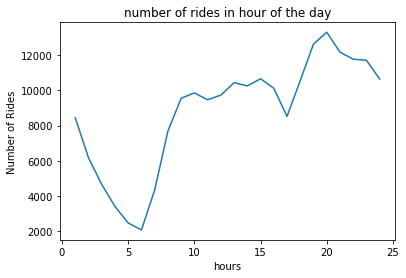

In [136]:
data = query_1.sort_values("hours")
plt.title("number of rides in hour of the day")
plt.xlabel("hours")
plt.ylabel("Number of Rides")
plt.plot(data["hours"], data["counts"])

### 2. Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.


In [168]:
# extract uber table
uber_table = """
SELECT *
FROM uber
"""
uber_rides = sqldf(uber_table)

# extract taxi table
taxi_table = """
SELECT *
FROM all_data
"""
taxi_rides = sqldf(taxi_table)

# combine uber table and taxi table
all_rides = pd.concat([uber_rides, taxi_rides], axis=0)

In [365]:
query = """
SELECT month, 
    AVG(distance) AS avg_dist, 
    SQRT(AVG(distance*distance) - AVG(distance)*AVG(distance)) AS std_dev,
    COUNT(*) as counts
FROM all_rides
GROUP BY month
"""

data = sqldf(query)
dev = 1.645 * data["std_dev"]/np.sqrt(data["counts"])
CI_left = data["avg_dist"] - dev
CI_right = data["avg_dist"] + dev

CI = pd.concat([CI_left, CI_right], axis=1)
CI.columns = ["CI_left", "CI_right"]
CI

,CI_left,CI_right
0,12.187911,17.557578
1,15.770665,22.361589
2,12.441879,17.820972
3,12.952882,18.314034
4,11.213283,15.997749
5,15.615295,21.667776
6,11.775655,17.481551
7,13.949892,20.819151
8,12.478653,18.299489
9,13.924746,19.902710


In [366]:
with open("Confidence_Interval.sql", "w+") as f:
        f.write(query)
        f.write('\n\n')

Text(0, 0.5, 'Average Distance')

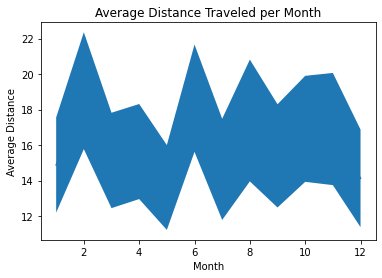

In [173]:
x = data["month"]
y = data["avg_dist"]
plt.plot(x, y)
plt.fill_between(x, (y-dev), (y+dev))
plt.title("Average Distance Traveled per Month")
plt.xlabel("Month")
plt.ylabel("Average Distance")

### 3. Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.

From the bar plot, Friday is the most popular day

In [305]:
LGA = [-73.882378, 40.762829, -73.856774, 40.779520]
JFK = [-73.794031, 40.638743, -73.774501, 40.650001]
EWR = [-74.196493, 40.678116, -74.154394, 40.705115]

In [306]:
def box(df, bbox):
    """ This is a box coordinate function"""
    df = df[(df["dropoff_longitude"] > bbox[0]) & (df["dropoff_longitude"] < bbox[2]) # longitude and latitude constraints
       & (df["dropoff_latitude"] > bbox[1]) & (df["dropoff_latitude"] < bbox[3])]
    return df

Find number of trips of three airports

In [338]:
#JFK
jfk_counts = box(all_data, JFK)
query = """
SELECT dayofweek +1 AS day, COUNT(*) AS jfk_counts
FROM jfk_counts
GROUP BY dayofweek +1
"""
jfk_counts = sqldf(query)

#LGA
lga_counts = box(all_data, LGA)
query = """
SELECT dayofweek +1 AS day, COUNT(*) AS lga_counts
FROM lga_counts
GROUP BY dayofweek +1
"""
lga_counts = sqldf(query)

#EWR
ewr_counts = box(all_data, EWR)
query = """
SELECT dayofweek +1 AS day, COUNT(*) AS ewr_counts
FROM ewr_counts
GROUP BY dayofweek +1
"""
ewr_counts = sqldf(query)

<AxesSubplot:title={'center':'Frequency of dropoff in Airports'}, xlabel='day', ylabel='Number of Rides'>

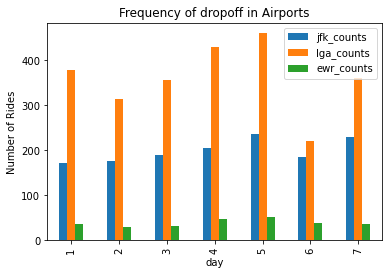

In [344]:
result = pd.merge(jfk_counts, lga_counts, on ='day')
result = pd.merge(result, ewr_counts, on="day")
result.plot(x="day", y=["jfk_counts", "lga_counts", "ewr_counts"], kind = "bar", title = "Frequency of dropoff in Airports", xlabel = "day", ylabel = "Number of Rides")



### 4. Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

In [179]:
map_dat = all_data
kep = KeplerGl(height=300)
kep.add_data(data=map_dat,name='Heatmap of New York Trips')
kep

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Heatmap of New York Trips': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1…

### 5. Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.

Text(0, 0.5, 'Tip Amount')

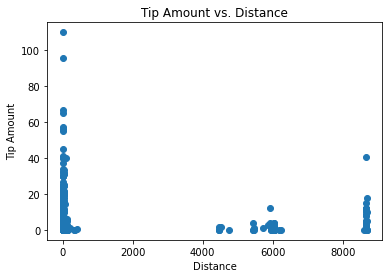

In [281]:
plt.scatter(taxi_rides["distance"], taxi_rides["tip_amount"])
plt.title("Tip Amount vs. Distance")
plt.xlabel("Distance")
plt.ylabel("Tip Amount")
#from the scatter plot, distance larger than 200 and tip amount larger than 80 are considered as outliers



Text(0, 0.5, 'Tip Amount')

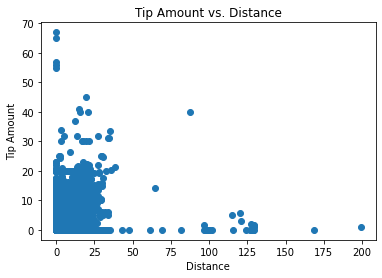

In [187]:
data = taxi_rides[(taxi_rides["distance"] < 200) & (taxi_rides["tip_amount"] < 80)]
plt.scatter(data["distance"], data["tip_amount"])
plt.title("Tip Amount vs. Distance")
plt.xlabel("Distance")
plt.ylabel("Tip Amount")

### 6. Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit

In [367]:
query7 = """
SELECT weather.year, 
weather.month, 
weather.day, 
weather.hour, 
weather.HourlyPrecipitation,
al.tip_amount

FROM hourly AS weather
INNER JOIN all_data AS al
ON weather.year = al.year 
    AND weather.month = al.month 
    AND weather.day = al.day 
    AND weather.hour = al.hour
"""
query_7 = sqldf(query7)
query_7.dropna(how='any', inplace=True)

#remove non-numeric rows
query_7 = query_7[query_7["HourlyPrecipitation"] != "T"]
query_7 = query_7[~query_7["HourlyPrecipitation"].str.contains("s")]
query_7

,year,month,day,hour,HourlyPrecipitation,tip_amount
1,2012,1,12,8,0.03,0.00
2,2012,1,12,8,0.03,0.00
3,2012,1,12,8,0.03,0.00
4,2012,1,12,8,0.03,0.00
5,2012,1,12,8,0.03,0.00
...,...,...,...,...,...,...
96823,2010,12,1,12,0.01,1.50
96880,2010,12,12,9,0.03,0.00
96881,2010,12,12,9,0.03,0.00
96882,2010,12,12,21,0.02,0.00


In [368]:
with open("Precipitation_vs_Tip_Amount.sql", "w+") as f:
        f.write(query7)
        f.write('\n\n')

Text(0, 0.5, 'Tip Amount')

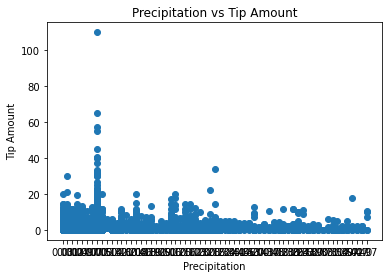

In [282]:
plt.scatter(query_7["HourlyPrecipitation"], query_7["tip_amount"])
plt.title("Precipitation vs Tip Amount")
plt.xlabel("Precipitation")
plt.ylabel("Tip Amount")
#from this plot, we consider tip amount larger than 40 as outliers

Text(0, 0.5, 'Tip Amount')

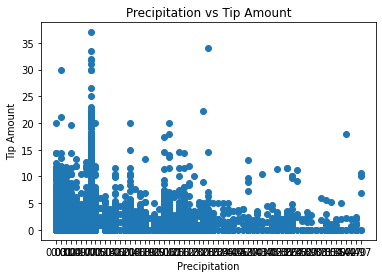

In [283]:
data = query_7[query_7["tip_amount"] < 40]
plt.scatter(data["HourlyPrecipitation"], data["tip_amount"])
plt.title("Precipitation vs Tip Amount")
plt.xlabel("Precipitation")
plt.ylabel("Tip Amount")

### 7. Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.

#### Question 1. What is the average tip amount in each month in 2012?

In [369]:
query8 = """
SELECT year, month, AVG(tip_amount) AS avg_tip_amount
FROM all_data
WHERE year = 2012
GROUP BY month
"""
query_8 = sqldf(query8)
query_8

,year,month,avg_tip_amount
0,2012,1,0.977423
1,2012,2,1.037749
2,2012,3,1.094512
3,2012,4,1.072654
4,2012,5,1.060640
5,2012,6,1.123931
6,2012,7,1.059499
7,2012,8,1.058252
8,2012,9,1.243365
9,2012,10,1.278272


In [370]:
with open("Average_Tip_Amount_in_2012.sql", "w+") as f:
        f.write(query8)
        f.write('\n\n')

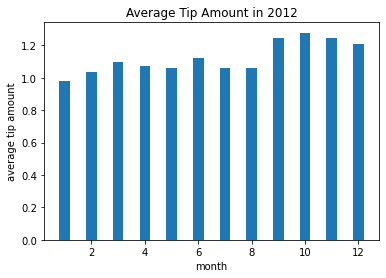

In [251]:
plt.bar(query_8["month"], query_8["avg_tip_amount"], width = 0.4)
plt.xlabel("month")
plt.ylabel("average tip amount")
plt.title("Average Tip Amount in 2012")
plt.show()

#### Question 2. How does distance relate to tip amount when there was precipitation in 2012?

In [371]:
query9 = """
SELECT weather.year, 
weather.month, 
weather.day,  
AVG(al.tip_amount) AS avg_tip_amount,
AVG(al.distance) AS avg_distance

FROM daily AS weather
INNER JOIN all_data AS al
ON weather.year = al.year 
    AND weather.month = al.month 
    AND weather.day = al.day 
WHERE 
    (weather.year = 2012) AND (weather.DailyPrecipitation > 0)
    
GROUP BY weather.month, weather.day
"""
query_9 = sqldf(query9)
query_9

,year,month,day,avg_tip_amount,avg_distance
0,2012,7,31,1.258298,3.226762
1,2012,8,1,1.059211,2.938188
2,2012,8,2,1.322083,93.727136
3,2012,8,3,1.351263,3.693735
4,2012,8,4,1.008172,3.635697
...,...,...,...,...,...
149,2012,12,27,0.999672,2.660629
150,2012,12,28,0.931412,105.539776
151,2012,12,29,0.955729,3.734283
152,2012,12,30,0.915195,3.160411


In [372]:
with open("Distance_and_Tip_Amount_in_2012.sql", "w+") as f:
        f.write(query9)
        f.write('\n\n')

Text(0, 0.5, 'Tips')

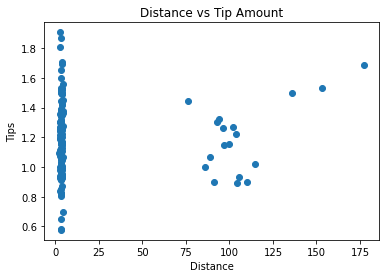

In [257]:
data = query_9
plt.scatter(data["avg_distance"], data["avg_tip_amount"])
plt.title("Distance vs Tip Amount")
plt.xlabel("Distance")
plt.ylabel("Tips")

#### Question 3. In each year, what is the number of rides of Uber vs. Yellow Taxi when there was precipitation?

In [373]:
query10 = """
SELECT COUNT(*) AS uber_counts, uber.year
FROM uber AS uber
INNER JOIN daily AS weather
ON weather.year = uber.year 
    
WHERE weather.DailyPrecipitation > 0
GROUP BY uber.year
"""
query_10 = sqldf(query10)
query_10

,uber_counts,year
0,4988984,2012
1,11386175,2013
2,10938320,2014
3,5024590,2015


In [375]:
with open("Uber_counts_precipitation.sql", "w+") as f:
        f.write(query10)
        f.write('\n\n')

In [374]:
query11 = """
SELECT COUNT(*) AS taxi_counts, al.year
FROM all_data AS al
INNER JOIN daily AS weather
ON weather.year = al.year 

WHERE weather.DailyPrecipitation > 0
GROUP BY al.year
"""
query_11 = sqldf(query11)
query_11

,taxi_counts,year
0,5392002,2012
1,12429710,2013
2,10841595,2014
3,5578295,2015


In [376]:
with open("Taxi_counts_precipitation.sql", "w+") as f:
        f.write(query11)
        f.write('\n\n')

<AxesSubplot:title={'center':'Number of Rides: Uber vs. Taxi'}, xlabel='Year', ylabel='Number of Rides'>

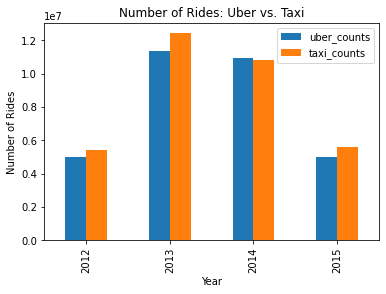

In [290]:
result = pd.merge(query_10, query_11, on ='year')
result.plot(x="year", y=["uber_counts", "taxi_counts"], kind = "bar", title = "Number of Rides: Uber vs. Taxi", xlabel = "Year", ylabel = "Number of Rides")

